In [1]:
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!ls -lh

total 112K
-rw-rw-r-- 1 rishabh.mondal rishabh.mondal 104K Jun  2  2023 dog.jpeg
-rw-rw-r-- 1 rishabh.mondal rishabh.mondal  761 Jul 19 23:29 florence_basic.ipynb
-rw-rw-r-- 1 rishabh.mondal rishabh.mondal   11 Jul 19 23:17 README.md


In [1]:
EXAMPLE_IMAGE_PATH = "dog.jpeg"

In [2]:

import io
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
import supervision as sv

# from google.colab import userdata
from IPython.core.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
from PIL import Image
from roboflow import Roboflow

ModuleNotFoundError: No module named 'supervision'

In [13]:
CHECKPOINT = "microsoft/Florence-2-large-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True)

ImportError: This modeling file requires the following packages that were not found in your environment: flash_attn, timm. Run `pip install flash_attn timm`

In [3]:
import os
os.environ['HF_HUB_ENABLE_HF_TRANSFER'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Monitoring
from tqdm.notebook import tqdm

# IO
from os.path import join, exists, basename, dirname
from glob import glob

# Parallel processing
from joblib import Parallel, delayed

import torch
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
from io import BytesIO

In [4]:
model_id = 'microsoft/Florence-2-base-ft'
f_base_ft_model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval().cuda()
f_base_ft_processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)


pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [5]:
def run_example(model, processor, image, task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

def plot_bbox(image, data, ax):      
    # Display the image  
    ax.imshow(image)  
      
    # Plot each bounding box  
    for bbox, label in zip(data['bboxes'], data['labels']):  
        # Unpack the bounding box coordinates  
        x1, y1, x2, y2 = bbox  
        # Create a Rectangle patch  
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')  
        # Add the rectangle to the Axes  
        ax.add_patch(rect)  
        # Annotate the label  
        ax.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))  
    
    # Remove the axis ticks and labels  
    ax.axis('off')
    return ax
    
def convert_to_od_format(data):  
    """  
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.  
  
    Parameters:  
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.  
  
    Returns:  
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.  
    """  
    # Extract bounding boxes and labels  
    bboxes = data.get('bboxes', [])  
    labels = data.get('bboxes_labels', [])  
      
    # Construct the output format  
    od_results = {  
        'bboxes': bboxes,  
        'labels': labels  
    }  
      
    return od_results  

In [7]:
task_prompt = "<OPEN_VOCABULARY_DETECTION>"
text_prompts = ["eye", "eyes", "two eyes", "both eyes", "left eye", "right eye", "eyebrow", "eyebrows", "ear", "ears", "teeth", "smile", "nose", "forehead", "face"]
image = Image.open('/home/patel_zeel/kilns_neurips24/lab/Face.jpeg').convert("RGB")

for text_prompt in tqdm(text_prompts):
    # for i, (model, processor, name) in enumerate(zip([f_large_model, f_large_ft_model], [f_large_processor, f_large_ft_processor], ['f_large', 'f_large_ft'])):
    for i, (model, processor, name) in enumerate(zip([f_base_ft_model], [f_base_ft_processor], ['f_base', 'f_base_ft', 'f_large', 'f_large_ft'])):
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        answer = run_example(model, processor, image, task_prompt, text_prompt)
        bbox_data = convert_to_od_format(answer['<OPEN_VOCABULARY_DETECTION>'])
        ax = plot_bbox(image, bbox_data, ax)
        save_name = f"/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/{name}_{text_prompt.replace(' ', '_')}.png"
        print(save_name)
        plt.savefig(save_name, bbox_inches='tight', pad_inches=0, dpi=100)
        plt.close()

  0%|          | 0/15 [00:00<?, ?it/s]

/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_eye.png
/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_eyes.png
/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_two_eyes.png
/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_both_eyes.png
/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_left_eye.png
/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_right_eye.png
/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_eyebrow.png
/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_eyebrows.png
/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_ear.png
/home/rishabh.mondal/Br

In [8]:
for text_prompt in text_prompts:
    print(f"""| {text_prompt} | {' | '.join([f"![{name}]({name}_{text_prompt.replace(' ', '_')}.png)" for name in ['f_base_ft']])} |""")

| eye | ![f_base_ft](/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_ft_eye.png) |
| eyes | ![f_base_ft](/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_ft_eyes.png) |
| two eyes | ![f_base_ft](/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_ft_two_eyes.png) |
| both eyes | ![f_base_ft](/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_ft_both_eyes.png) |
| left eye | ![f_base_ft](/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_ft_left_eye.png) |
| right eye | ![f_base_ft](/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_ft_right_eye.png) |
| eyebrow | ![f_base_ft](/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_ft_eyebrow.png) |
| eyebrows | ![f_base_

['/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_eye.png', '/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_eyes.png', '/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_two_eyes.png', '/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_both_eyes.png', '/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_left_eye.png', '/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_right_eye.png', '/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_eyebrow.png', '/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_eyebrows.png', '/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/f_base_ear.p

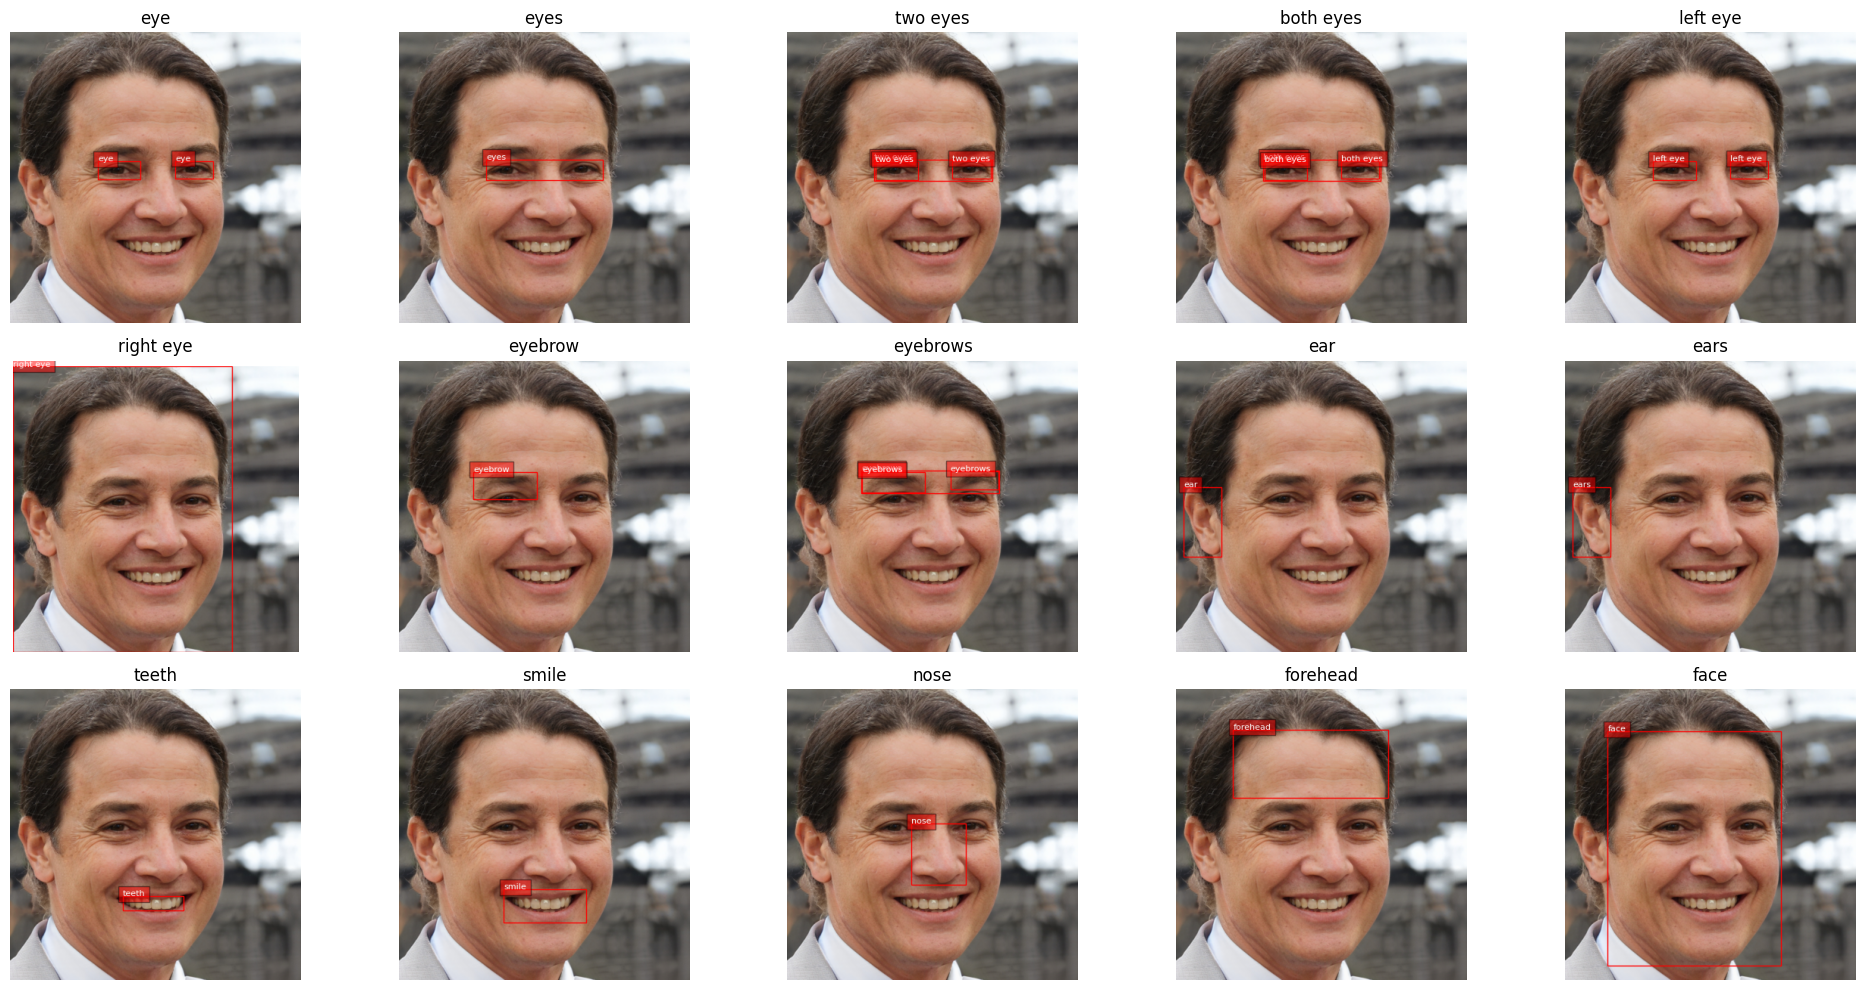

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the paths to your images
# Define the common path and labels for the images
base_path = "/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/YOLO_LOCALIZATION/bsys_2024/"
labels = [
    "eye", "eyes", "two_eyes", "both_eyes", "left_eye", "right_eye",
    "eyebrow", "eyebrows", "ear", "ears", "teeth", "smile", "nose",
    "forehead", "face"
]

# Generate the full image paths using a list comprehension
image_paths = [f"{base_path}f_base_{label}.png" for label in labels]

print(image_paths)

# Define corresponding labels for the images
labels = [
    "eye", "eyes", "two eyes", "both eyes", "left eye", "right eye",
    "eyebrow", "eyebrows", "ear", "ears", "teeth", "smile", "nose",
    "forehead", "face"
]

# Number of images
n_images = len(image_paths)

# Determine the number of rows and columns for the subplots
n_cols = 5
n_rows = (n_images + n_cols - 1) // n_cols  # This ensures we have enough rows

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Load and plot each image in its subplot
for i, (img_path, label) in enumerate(zip(image_paths, labels)):
    img = mpimg.imread(img_path)
    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis('off')  # Hide axes ticks

# Hide any remaining empty subplots
for i in range(n_images, n_rows * n_cols):
    axes[i].axis('off')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()
